# Tarea. Filtros sobre Imágenes
## Diplomado En Ciencia De Datos_Modulo 6
### Melchor López Ortiz

Utilizar un modelo SVC para clasificar un conjunto de imágenes en dos clases diferentes, el modelo analizará una base de datos con dos entradas diferentes cuyo tema son los elefantes, las dos clases son elefantes africanos y asiaticos.



Fuente: https://www.kaggle.com/datasets/vivmankar/asian-vs-african-elephant-image-classification

Se aplicaran dos optimizadores diferentes para medir cual de los dos da los mejores resultados en el modelo.

In [17]:
# Importar las Librerías
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.feature import canny, hog
from skimage.transform import resize
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from skopt import BayesSearchCV


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Importar y ajustar la base de datos, aplicar filtros.

Data = '/content/drive/MyDrive/1 Prueba/dataset/test'
categories = ['African', 'Asian']
image_size = (64, 64)

data = []
labels = []
example_images = {}

for category_idx, category in enumerate(categories):
    category_path = os.path.join(Data, category)
    for file in os.listdir(category_path):
        img_path = os.path.join(category_path, file)
        try:
            img = imread(img_path)
            if img.ndim == 3 and img.shape[-1] == 4:
                img = img[:, :, :3]
            if img.ndim != 3 or img.shape[-1] != 3:
                print(f"Saltando imagen mal formada: {img_path}")
                continue
            img = resize(img, image_size)
            gray = rgb2gray(img)
            blurred = gaussian(gray, sigma=1)
            features = hog(blurred,
               pixels_per_cell=(4, 4),
               cells_per_block=(2, 2),
               orientations=9,
               block_norm='L2-Hys')
            data.append(features)
            labels.append(category_idx)
            if category not in example_images:
                example_images[category] = {
                    "original": img,
                    "gray": gray,
                    "blurred": blurred
                }

        except Exception as e:
            print(f"Error al procesar {img_path}: {e}")

X = np.array(data)
y = np.array(labels)


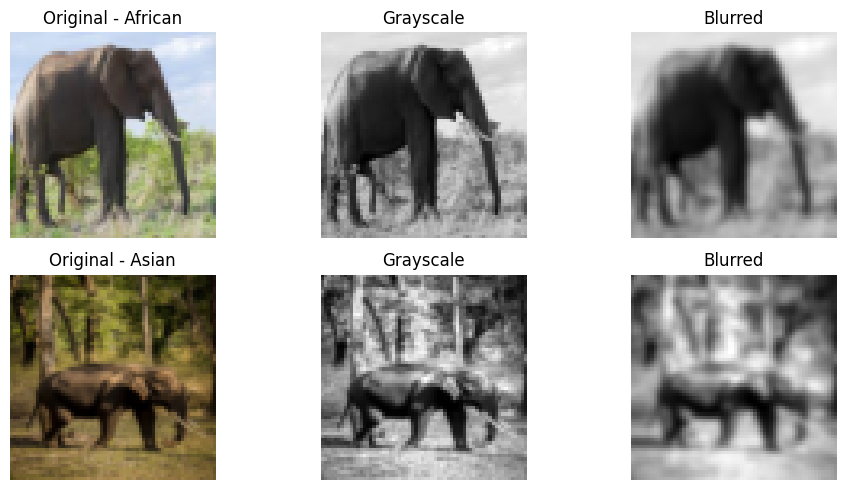

In [6]:
# Visualizar los filtros aplicados
fig, axes = plt.subplots(len(categories), 3, figsize=(10, 5))
for i, category in enumerate(categories):
    img_set = example_images[category]
    axes[i, 0].imshow(img_set["original"])
    axes[i, 0].set_title(f"Original - {category}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(img_set["gray"], cmap='gray')
    axes[i, 1].set_title("Grayscale")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(img_set["blurred"], cmap='gray')
    axes[i, 2].set_title("Blurred")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


In [7]:
# División y escalado de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Modelo (GridSearch)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf','poly'],
    'degree': [3]
}

svm = SVC()
grid = GridSearchCV(svm, param_grid, cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'degree': [3],
                         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf', 'poly']},
             verbose=1)

In [9]:
# Evaluación del primer modelo (GridSearch)
print("Mejores parámetros:")
print(grid.best_params_)

y_pred = grid.predict(X_test_scaled)

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

Mejores parámetros:
{'C': 0.01, 'degree': 3, 'gamma': 0.001, 'kernel': 'poly'}
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        20
           1       0.64      0.78      0.70        18

    accuracy                           0.68        38
   macro avg       0.69      0.69      0.68        38
weighted avg       0.70      0.68      0.68        38

Matriz de confusión:
[[12  8]
 [ 4 14]]


In [15]:
# Modelo 2 (BayesSearch)
search_space = {
    'C': (0.01, 100.0, 'log-uniform'),
    'gamma': (1e-4, 1.0, 'log-uniform'),
    'kernel': ['rbf', 'poly'],
    'degree': (2, 5),
}

svm = SVC()
opt = BayesSearchCV(
    svm,
    search_spaces=search_space,
    n_iter=60,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

opt.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [100.0, np.int64(3), 1.0, np.str_('poly')] before, using random point [1.2901388856646925, np.int64(3), 0.010662786191793935, 'rbf']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=5, estimator=SVC(), n_iter=60, n_jobs=-1, random_state=42,
              scoring='accuracy',
              search_spaces={'C': (0.01, 100.0, 'log-uniform'),
                             'degree': (2, 5),
                             'gamma': (0.0001, 1.0, 'log-uniform'),
                             'kernel': ['rbf', 'poly']},
              verbose=1)

In [16]:
# Evaluación del segundo modelo (BayesSearch)
print("Mejores parámetros:")
print(opt.best_params_)

y_pred = opt.predict(X_test_scaled)

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

Mejores parámetros encontrados:
OrderedDict([('C', 17.76576664980768), ('degree', 3), ('gamma', 0.02467108843522573), ('kernel', 'poly')])
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.73      0.55      0.63        20
           1       0.61      0.78      0.68        18

    accuracy                           0.66        38
   macro avg       0.67      0.66      0.66        38
weighted avg       0.67      0.66      0.65        38

Matriz de confusión:
[[11  9]
 [ 4 14]]


## Conclusiones
Las diferencias entre el modelo optimizado con GridSearch y el modelo que utiliza BayesSearch fue minima, los resultados obtenidos muy probablemente se deben a la base de datos que fue utilizada, pues esta es la carpeta Test que es mucho pequeña que train y no fue utilizada por razones de procesamiento, con la aplicación de estos optimizadores y recibir estos resultados es posible observar que no existe mucha variación entre ambos al enfrentarse a bases de datos de este tamaño, por dicha razón el modelo Grid fue el que mejor se desempeñó, por muy poco, pues basado en su análisis más amplio y menos especializado este obtuvo mejores resultados en la clasificación.

A la hora de aplicar distintos optimizadores para un modelo es posible encontrar cual es el mejor curso de acción para el desarrollo del codigo, pues muchos factores afectan su funcionamiento; como puede ser el tamaño de las imagenes, los filtros aplicados o la forma en la que se limpien y presenten nuestras bases de datos, por dicha razón es necesario analizar todas las opciones posibles para nuestro modelo y siempre hacer comparaciones.

### Por qué se utilizo BayesSearch

BayesSearch utiliza un modelo probabilístico de optimización bayesiana, esta misma analiza y aprende a medida que analiza que parámetros son más prometedores para el modelo de una manera más inteligente que GridSearch que utiliza todas las combinaciones posibles, por esta misma razón podría considerarse una mejora sustancial a la hora de optimizar un modelo de clasificación.

Al tratarse de un modelo probabilístico este aprende con el tiempo y necesita un menor número de pruebas para llevar a cabo un análisis exhaustivo de los hiperparámetros, además de ser más eficiente a la hora de aplicarse a muestreos grandes.

Al aplicar dos optimizadores distintos en una misma base de datos es posible encontrar un mayor contraste entre ambos resultados del modelo, lo cual es de ayuda a la hora de señalar las características clave de la misma.